# Sea Ice Extent Timeseries
## **ECCO**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.e0acc655e4f942f3b8eea2bc64620402 Dashboard: /services/dask-gateway/clusters/prod.e0acc655e4f942f3b8eea2bc64620402/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
client.close()
cluster.close()

In [14]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import json
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [7]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [8]:
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coordsr = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
dsr = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)

In [9]:
#view current coord structure of i
coordsr.i.values
#locate 0, that's where -180 is
coordsr.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
dsr['i'] = lon_rolled
dsr['i_g'] = lon_rolled
coordsr['i'] = lon_rolled
coordsr['i_g'] = lon_rolled

In [10]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))
lat_range_u = dict(j_g=slice(lower_lat, upper_lat))
lon_range_u = dict(i_g=slice(left_lon, right_lon))

t = 30
level = 0

coords = coordsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = dsr.isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

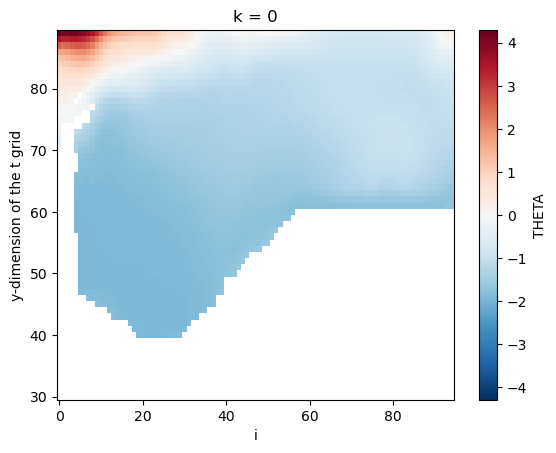

In [11]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0]>0)
sst_mean.where(surface_mask).drop('i').plot()

In [27]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

#si = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/seaice.zarr'), consolidated=False)

si = xr.open_dataset('sea-ice-wg-ecco.nc')

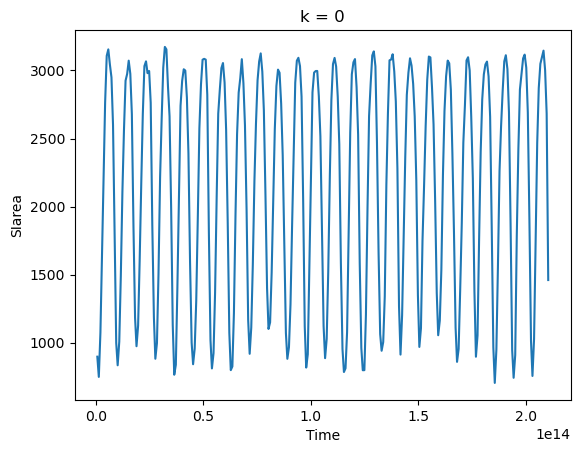

In [28]:
si.SIarea.sum(['i','j']).plot()

In [29]:
coords.rA

<xarray.DataArray 'rA' (j: 60, i: 95)>
dask.array<getitem, shape=(60, 95), dtype=float32, chunksize=(60, 67), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

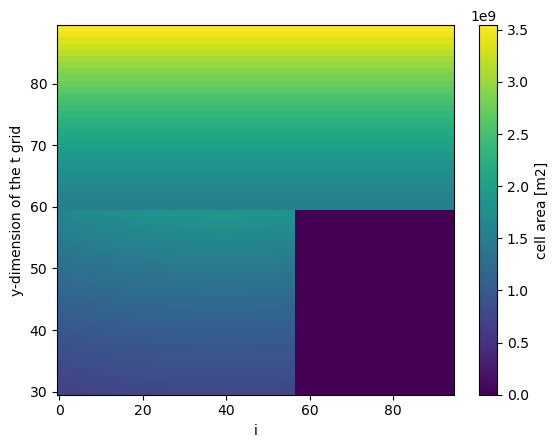

In [30]:
coords.rA.drop('i').plot()

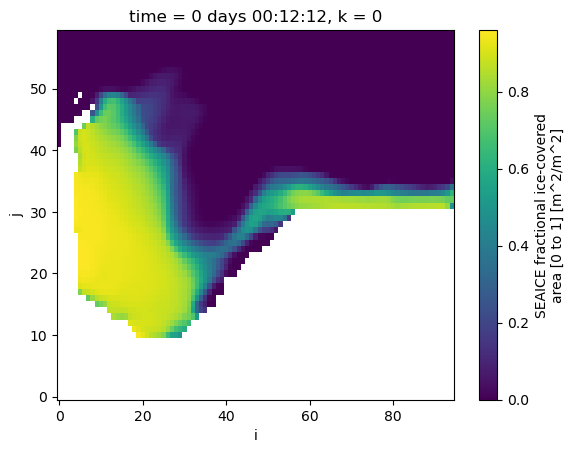

In [31]:
si.SIarea[0].plot()

In [34]:
coords.rA

<xarray.DataArray 'rA' (j: 60, i: 95)>
dask.array<getitem, shape=(60, 95), dtype=float32, chunksize=(60, 67), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [35]:
si.SIarea.coords

Coordinates:
  * time     (time) timedelta64[ns] 00:12:12 00:23:48 ... 2 days 10:26:00
    k        int64 0

In [36]:
area = coords.rA
weighted_area = si.SIarea * area

In [37]:
weighted_area

<xarray.DataArray (time: 288, j: 60, i: 95)>
dask.array<multiply, shape=(288, 60, 95), dtype=float32, chunksize=(288, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 00:12:12 00:23:48 ... 2 days 10:26:00
    k        int64 0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89

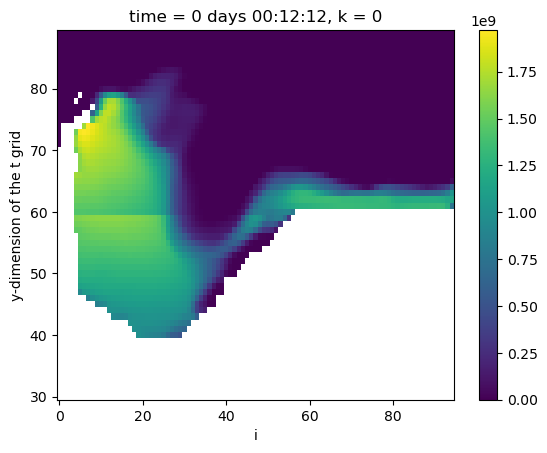

In [39]:
weighted_area[0].drop('i').plot()

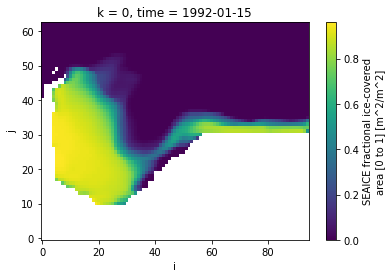

In [20]:
si.SIarea[0].plot()

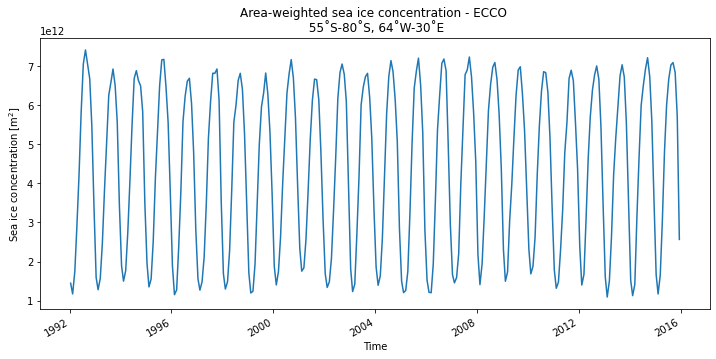

In [21]:
plt.figure(figsize=(12,5))
weighted_area.sum(['i', 'j']).plot()
plt.title('Area-weighted sea ice concentration - ECCO \n 55˚S-80˚S, 64˚W-30˚E')
plt.ylabel(r'Sea ice concentration [m$^2$]');

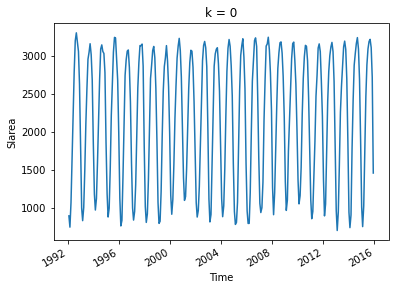

In [22]:
si.SIarea.sum(['i', 'j']).plot();

In [23]:
weighted_area

<xarray.DataArray (time: 288, j: 63, i: 95)>
dask.array<mul, shape=(288, 63, 95), dtype=float32, chunksize=(72, 32, 48), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

In [41]:
weighted_area

<xarray.DataArray (time: 288, j: 60, i: 95)>
dask.array<multiply, shape=(288, 60, 95), dtype=float32, chunksize=(288, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 00:12:12 00:23:48 ... 2 days 10:26:00
    k        int64 0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89

In [43]:
weighted_area['time'] = coords.time

In [44]:
ice_anom = weighted_area.groupby('time.month') - weighted_area.groupby('time.month').mean()
ice_anom

<xarray.DataArray (time: 288, j: 60, i: 95)>
dask.array<sub, shape=(288, 60, 95), dtype=float32, chunksize=(288, 60, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

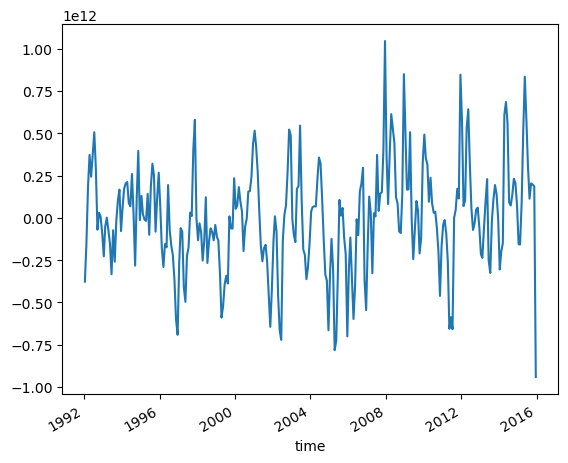

In [45]:
ice_anom.sum(['j', 'i']).plot()

In [46]:
si_index = ice_anom.sum(['j', 'i'])/ ice_anom.sum(['j', 'i']).std(dim='time')
si_index

<xarray.DataArray (time: 288)>
dask.array<truediv, shape=(288,), dtype=float32, chunksize=(288,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

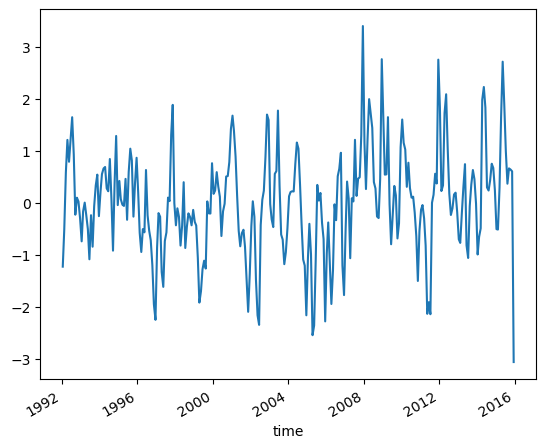

In [47]:
si_index.plot()

## SAM Index

In [28]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [29]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [30]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [31]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [32]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

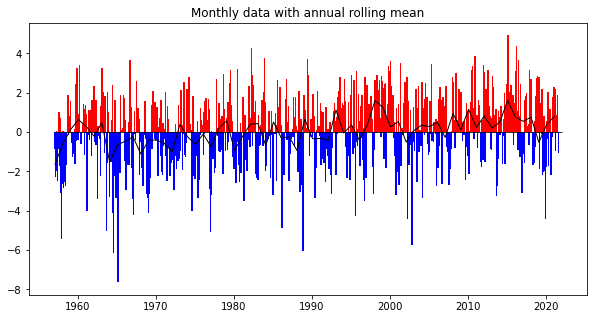

In [33]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [34]:
si.SIarea.sum(['i', 'j'])

<xarray.DataArray 'SIarea' (time: 288)>
dask.array<sum-aggregate, shape=(288,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [35]:
ann_seas.ANN.loc['1992':'2016']

time
1992-01-01   -0.96
1993-01-01    3.28
1994-01-01   -0.29
1995-01-01    1.19
1996-01-01   -1.04
1997-01-01    1.16
1998-01-01    4.46
1999-01-01    3.67
2000-01-01    0.26
2001-01-01    1.57
2002-01-01   -1.32
2003-01-01    0.35
2004-01-01    1.17
2005-01-01    0.30
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
2012-01-01    2.11
2013-01-01    0.30
2014-01-01    1.31
2015-01-01    4.13
2016-01-01    1.67
Name: ANN, dtype: float64

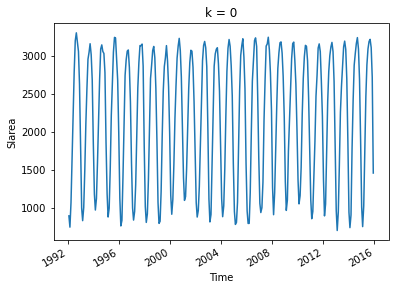

In [36]:
si.SIarea.sum(['i','j']).plot()

<AxesSubplot:xlabel='time'>

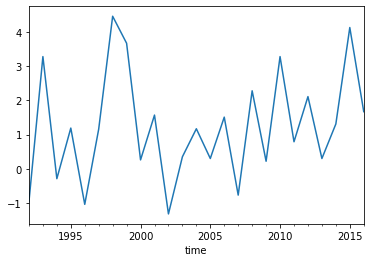

In [37]:
ann_seas.ANN.loc['1992':'2016'].plot()

In [38]:
ann_xr = ann_seas.ANN.to_xarray()

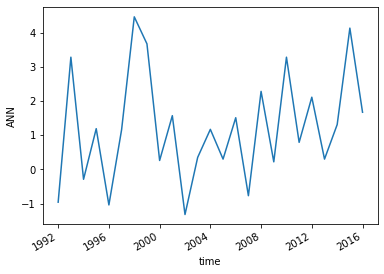

In [39]:
ann_xr.sel(time=slice('1992', '2016')).plot()

In [40]:
si.SIarea.sum(['i','j'])

<xarray.DataArray 'SIarea' (time: 288)>
dask.array<sum-aggregate, shape=(288,), dtype=float32, chunksize=(72,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [41]:
si.SIarea.sum(['i','j']).time

<xarray.DataArray 'time' (time: 288)>
array(['1992-01-15T00:00:00.000000000', '1992-02-13T00:00:00.000000000',
       '1992-03-15T00:00:00.000000000', ..., '2015-10-15T00:00:00.000000000',
       '2015-11-14T00:00:00.000000000', '2015-12-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    k        int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [42]:
corr_mo_timeinterp = xr.corr(si.SIarea.sum(['i','j']), mo_xr.sel(time=slice('1992', '2015')).interp(time=si.SIarea.time), dim='time').values
corr_mo_timeinterp

array(-0.17191613)

In [43]:
corr_mo = xr.corr(si.SIarea.sum(['i','j']), mo_xr.sel(time=slice('1992', '2015')), dim='time').values
corr_mo

array(nan)

In [44]:
corr_ann = xr.corr(si.SIarea.sum(['i','j']), ann_xr.sel(time=slice('1992', '2015')), dim='time').values
corr_ann

array(nan)

### **ECCO's sea ice extent is weakly correlated with SAM index between 1992 through 2015**

## Saving Data

In [4]:
ice = xr.open_dataarray('sea-ice-ecco')

In [5]:
ice = ice.to_dataset()

In [6]:
ice

<xarray.Dataset>
Dimensions:  (i: 95, j: 63, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 ...
Dimensions without coordinates: i, j
Data variables:
    SIarea   (time, j, i) float32 ...

In [29]:
si_index

<xarray.DataArray (time: 288)>
dask.array<truediv, shape=(288,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 0
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [31]:
si_index_ds = si_index.to_dataset(name='ecco_si_index')

In [32]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [8]:
#uploading seaice 
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/seaice.zarr')
ice.to_zarr(gcsmap_seaice, mode='w')

In [33]:
#uploading ecco seaice index 
gcsmap_si_index = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ecco_si_index.zarr')
si_index_ds.to_zarr(gcsmap_si_index, mode='w')

## Timeseries

In [4]:
ecco = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ecco_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_mo_anom')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [5]:
ecco_ms_time = ecco.assign_coords(coords={'time':enso.sel(time=slice('1992', '2015')).time})
ecco_ms_time

<xarray.Dataset>
Dimensions:        (time: 288)
Coordinates:
    k              int64 ...
    month          (time) int64 ...
  * time           (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
Data variables:
    ecco_si_index  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [6]:
enso.sel(time=slice('1992', '2015'))

<xarray.DataArray 'sst' (time: 288)>
array([1.883747, 1.786449, 1.614739, ..., 2.599419, 2.746488, 2.794896],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 ...

In [7]:
sam_ms_time = sam.sel(time=slice('1992', '2015')).assign_coords(coords={'time':enso.sel(time=slice('1992', '2015')).time})
sam_ms_time

<xarray.DataArray (time: 288)>
array([-0.217692, -1.573846, -1.094462, ..., -0.682969,  1.481406,  0.56625 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 ...

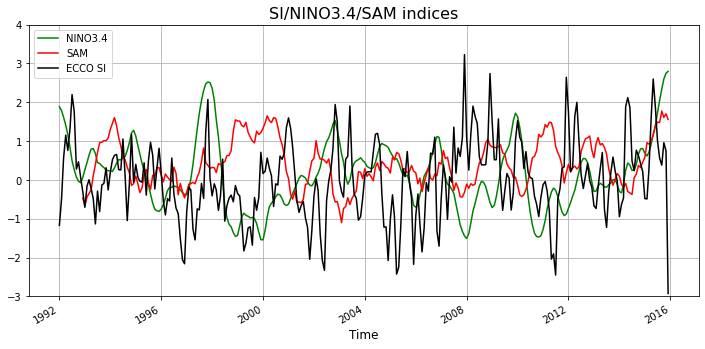

In [8]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('1992', '2015')).plot(color='green', label='NINO3.4')
sam_ms_time.rolling(time=12).mean().plot(color='red', label='SAM') #12mth rolling mean
ecco_ms_time.ecco_si_index.plot(color='k', label='ECCO SI')
plt.legend()
plt.grid()
plt.ylim(-3,4) #ylims with rolling mean
#plt.ylim(-6,6) #ylims without rolling mean
#plt.xlim('1992-01-01', '2015-12-01')
plt.title('SI/NINO3.4/SAM indices', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('');

In [9]:
enso.sel(time=slice('1992', '2015'))

<xarray.DataArray 'sst' (time: 288)>
array([1.883747, 1.786449, 1.614739, ..., 2.599419, 2.746488, 2.794896],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 ...

In [10]:
sam_ms_time.rolling(time=12).mean()

<xarray.DataArray (time: 288)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.4649403 , -0.6599403 , -0.43827364, -0.3549403 ,
       -0.24910697,  0.10839303,  0.4025597 ,  0.70422636,  0.96172636,
        0.96839303,  1.01089303,  1.0100597 ,  1.07672636,  1.30172636,
        1.46422636,  1.6050597 ,  1.3925597 ,  1.0925597 ,  0.8650597 ,
        0.6175597 ,  0.52089303,  0.32422636,  0.18422636, -0.14160697,
       -0.0974403 ,  0.09922636, -0.10160697, -0.3274403 , -0.20327364,
        0.14172636,  0.2700597 , -0.0724403 , -0.2424403 ,  0.11672636,
        0.09839303,  0.3150597 ,  0.31672636,  0.12172636, -0.04910697,
        0.15339303,  0.06839303,  0.00672636, -0.04410697,  0.32922636,
        0.16672636, -0.3824403 , -0.0924403 , -0.30327364, -0.46160697,
       -0.3099403 , -0.10827364, -0.09827364, -0.0624403 , -0.10160697,
        0.0725597 ,  0.20589303,  0.47422636,  0.82339303,  0.4425597 ,
        0.3750597 ,  0.29839303,  0.32172636,  0.3125597 ,  0.18922636,
        0.4175597 ,  0.39089303,  0.4425597 ,  0.46839303,  0.62672636,
        0.63089303,  0.7575597 ,  1.25839303,  1.54839303,  1.51589303,
        1.5150597 ,  1.40339303,  1.36589303,  1.4825597 ,  1.2225597 ,
        1.1050597 ,  1.00339303,  0.9550597 ,  1.25589303,  1.17172636,
        1.21589303,  1.32672636,  1.47339303,  1.65089303,  1.52839303,
...
       -0.44160697, -0.3199403 , -0.10910697, -0.2149403 , -0.09827364,
       -0.13827364, -0.10827364,  0.19589303,  0.4375597 ,  0.51089303,
        0.70589303,  0.96172636,  1.0450597 ,  0.89589303,  0.85089303,
        0.83839303,  0.8275597 ,  0.85922636,  0.9025597 ,  0.6975597 ,
        0.6675597 ,  0.41422636,  0.31089303,  0.24922636,  0.06339303,
        0.0700597 , -0.13160697, -0.38660697, -0.4249403 , -0.3824403 ,
       -0.2449403 , -0.02827364,  0.26339303,  0.5700597 ,  0.6075597 ,
        0.75089303,  1.17422636,  1.10422636,  1.1775597 ,  1.42672636,
        1.3575597 ,  1.48589303,  1.47422636,  1.2725597 ,  0.8650597 ,
        0.70089303,  0.57922636,  0.3625597 , -0.07827364,  0.18672636,
        0.40339303,  0.20339303,  0.30922636,  0.35589303,  0.28089303,
        0.3425597 ,  0.73422636,  0.90672636,  1.06339303,  1.08339303,
        1.13089303,  0.7700597 ,  0.5725597 ,  0.93672636,  1.08922636,
        0.90172636,  0.93589303,  0.83339303,  0.66589303,  0.28339303,
        0.04922636, -0.13577364,  0.02339303,  0.1625597 ,  0.0925597 ,
       -0.11410697, -0.1949403 , -0.09077364, -0.29910697, -0.33577364,
       -0.37660697,  0.05839303,  0.1500597 ,  0.37589303,  0.31589303,
        0.45589303,  0.57922636,  0.95922636,  0.92089303,  0.99172636,
        1.16089303,  1.37922636,  1.48922636,  1.4800597 ,  1.77422636,
        1.60922636,  1.70172636,  1.5575597 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [11]:
ecco_ms_time.ecco_si_index

<xarray.DataArray 'ecco_si_index' (time: 288)>
dask.array<xarray-ecco_si_index, shape=(288,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01

## Butterworth filter

In [12]:
from scipy import signal
from scipy import fft

In [14]:
ecco_ms_time.ecco_si_index

<xarray.DataArray 'ecco_si_index' (time: 288)>
dask.array<xarray-ecco_si_index, shape=(288,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    k        int64 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01

In [32]:
filt_ecco = signal.sosfilt(signal.butter(3, (1/5), output='sos'), ecco_ms_time.ecco_si_index)
filt_ecco

array([-0.02117927, -0.10964913, -0.2478962 , -0.30905886, -0.18344591,
        0.1114375 ,  0.50029612,  0.93375048,  1.32595406,  1.52689632,
        1.45206319,  1.14701374,  0.70903808,  0.23888738, -0.15146249,
       -0.37717463, -0.44189742, -0.43273059, -0.44097633, -0.48787558,
       -0.54023048, -0.55468609, -0.49405926, -0.35860795, -0.19604629,
       -0.04616577,  0.09717358,  0.2494238 ,  0.3953621 ,  0.49389831,
        0.53026941,  0.53706758,  0.5044422 ,  0.36644606,  0.15826458,
        0.023232  ,  0.02140406,  0.09527432,  0.17257199,  0.20499275,
        0.18737899,  0.1483331 ,  0.10655872,  0.09421449,  0.16378827,
        0.29778172,  0.40131716,  0.42978442,  0.42450347,  0.4002157 ,
        0.30043651,  0.08932011, -0.18177696, -0.40391349, -0.48525607,
       -0.43877662, -0.3750426 , -0.39618705, -0.55465421, -0.85978616,
       -1.23815375, -1.51871104, -1.54589074, -1.33053679, -1.04958608,
       -0.87418245, -0.82839666, -0.82792801, -0.78943893, -0.66

In [28]:
filt_ecco.shape

(288,)

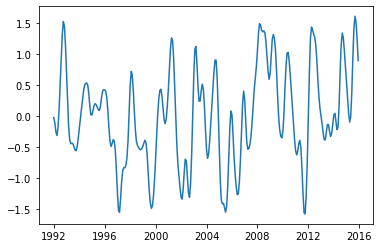

In [33]:
plt.plot(ecco_ms_time.time, filt_ecco) #SUCCESS - took out high-freq stuff

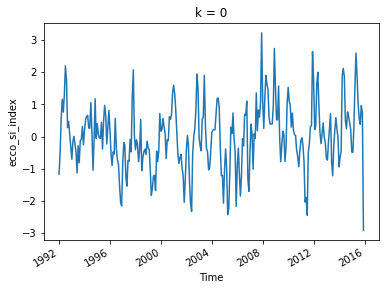

In [20]:
ecco_ms_time.ecco_si_index.plot()

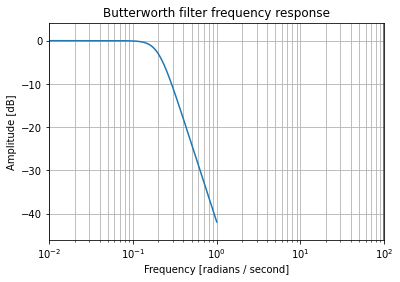

In [34]:
#This is what your filter looks like with inputs 3, (1/5)
b, a = signal.butter(3, (1/5), 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [35]:
sam_ms_time

<xarray.DataArray (time: 288)>
array([-0.217692, -1.573846, -1.094462, ..., -0.682969,  1.481406,  0.56625 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [37]:
enso.sel(time=slice('1992', '2015'))

<xarray.DataArray 'sst' (time: 288)>
array([1.883747, 1.786449, 1.614739, ..., 2.599419, 2.746488, 2.794896],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2015-12-01
    month    (time) int64 ...

In [39]:
filt_sam = signal.sosfilt(signal.butter(3, (1/5), output='sos'), sam_ms_time)
filt_enso = signal.sosfilt(signal.butter(3, (1/5), output='sos'), enso.sel(time=slice('1992', '2015')))

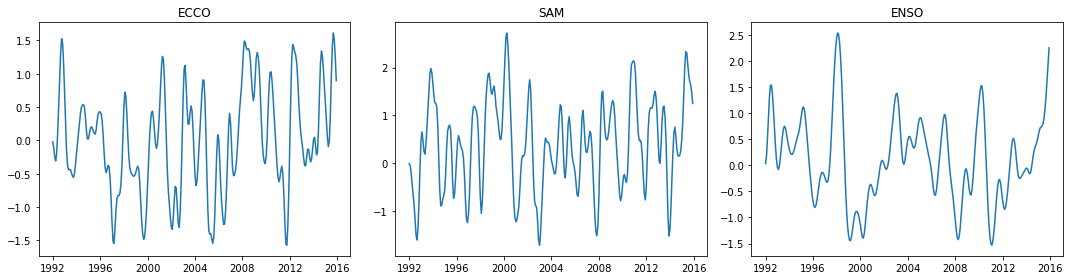

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].plot(ecco_ms_time.time, filt_ecco)
ax[0].set_title('ECCO')
ax[1].plot(ecco_ms_time.time, filt_sam)
ax[1].set_title('SAM')
ax[2].plot(ecco_ms_time.time, filt_enso)
ax[2].set_title('ENSO')
plt.tight_layout();

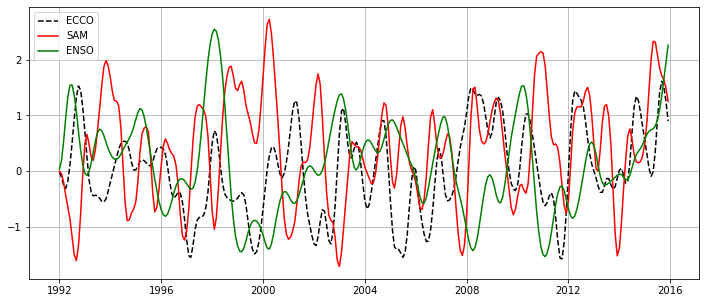

In [44]:
plt.figure(figsize=(12,5))
plt.plot(ecco_ms_time.time, filt_ecco, color='k', label='ECCO', linestyle='--')
plt.plot(ecco_ms_time.time, filt_sam, color='r', label='SAM')
plt.plot(ecco_ms_time.time, filt_enso, color='g', label='ENSO')
#plt.xlim(ecco_ms_time.time[0], ecco_ms_time.time[-1])
plt.legend()
plt.grid();

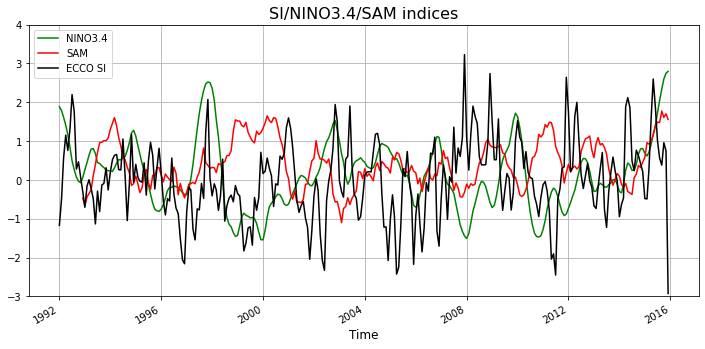

In [8]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('1992', '2015')).plot(color='green', label='NINO3.4')
sam_ms_time.rolling(time=12).mean().plot(color='red', label='SAM') #12mth rolling mean
ecco_ms_time.ecco_si_index.plot(color='k', label='ECCO SI')
plt.legend()
plt.grid()
plt.ylim(-3,4) #ylims with rolling mean
#plt.ylim(-6,6) #ylims without rolling mean
#plt.xlim('1992-01-01', '2015-12-01')
plt.title('SI/NINO3.4/SAM indices', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('');